## Гибридные рекомендательные системы с Surprise: взвешенный подход
### Мы используем Suprise (пакет sci-kit для рекомендательных систем), чтобы гарантировать, что рекомендательные системы, которые мы используем, оптимизированы, чтобы когда мы объединили их - не беспокоились о недостатках, возникающих в отдельной реализации. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install surprise

     |████████████████████████████████| 11.8MB 5.2MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618264 sha256=96582271c05e78b12433941908991d9d9dd30d25c3b045cd864bfba9947621bd
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [3]:
import surprise
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader
from surprise import model_selection
from surprise import accuracy
from surprise import prediction_algorithms
import pickle


import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import os
path = "/"

Во-первых, давайте прочитаем и очистим набор данных, чтобы мы знали, с чем работаем.
1. Считайте pandas датафрейм ratings.csv
2. Удалите дублированные строки
3. Сколько уникальных книг и пользователей в датасете?
4. В каком интервале рейтинг?

### 1. Считайте pandas датафрейм ratings.csv

In [4]:
ratings = pd.read_csv('/content/drive/MyDrive/ratings.csv')
ratings

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


### 2. Удалите дублированные строки

In [5]:
ratings.drop_duplicates()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


### 3. Сколько уникальных книг и пользователей в датасете?

In [6]:
unique_books = ratings['book_id'].unique()
unique_users = ratings['user_id'].unique()

print(f'Count unique books = {len(unique_books)}')
print(f'Count unique users = {len(unique_users)}')

Count unique books = 10000
Count unique users = 53424


### 4. В каком интервале рейтинг?

In [7]:
lower_rating = min(ratings['rating'])
upper_rating = max(ratings['rating'])

print(f'Rating has interval {lower_rating} - {upper_rating}')

Rating has interval 1 - 5


Всякий раз, когда вы загружаете набор данных в Surprise, вы можете использовать их класс Reader набора данных, который облегчает большую часть проблем. Вы можете указать множество форматов файлов, но для фреймов данных pandas, которые мы используем, вы можете указать некоторые параметры для рейтинга (rating_scale) и фрейма данных.

In [8]:
#порядок колонок должен быть таким
raw=ratings[['user_id','book_id','rating']]
raw.columns = ['n_users','n_items','rating']

# укажем scale для рейтинга
reader = Reader(rating_scale = (lower_rating, upper_rating)) 

# разделите на основную и отложенную выборки в соотножении 3:1
# и загрузите в surprise dataset:
raw_train_raws_count = int (len(ratings) / 4 * 3)
raw_holdout_raws_count = int (len(ratings) / 4)
raw_train,raw_holdout = raw[:raw_train_raws_count], raw[-raw_holdout_raws_count:]
data = Dataset.load_from_df(raw_train, reader)
holdout = Dataset.load_from_df(raw_holdout, reader)

In [50]:
raw_train

,n_users,n_items,rating
0,314,1,5
1,439,1,3
2,588,1,5
3,1169,1,4
4,1185,1,4
...,...,...,...
736312,994,7414,4
736313,1476,7414,3
736314,1566,7414,2
736315,1733,7414,2


In [66]:
raw_holdout

,n_users,n_items,rating
736317,2212,7414,5
736318,2462,7414,4
736319,2513,7414,3
736320,2591,7414,2
736321,2758,7414,4
...,...,...,...
981751,48386,10000,5
981752,49007,10000,4
981753,49383,10000,5
981754,50124,10000,5



### Во-первых, выберем несколько алгоритмов для включения в наш ансамбль. Это будут
1. KNN совместная фильтрация 
2. Факторизация матрицы
3. Совместная фильтрация с совместной кластеризацией
4. Совместная фильтрация на основе популярного алгоритма Slope One.

KNN совместная фильтрация:

In [12]:
from sklearn.metrics import mean_squared_error
from surprise.model_selection import KFold
from surprise import accuracy

rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
kSplit = surprise.model_selection.split.KFold(n_splits=10, shuffle=True)
sim_options = sim_options = {'name': 'cosine',
'user_based': False # Для подсчета сходства
}
collabKNN = surprise.KNNBasic(k=40,sim_options=sim_options)
rmseKNN = []
# -- TODO --
for trainset, testset in kSplit.split(data): #проходимся по фолдам
  collabKNN.fit(trainset)
  predictions = collabKNN.test(testset)
  rmseKNN.append(surprise.accuracy.rmse(predictions))

print(rmseKNN)

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

### Вы можете пробовать разные гиперпараметры, используя Suprise Grid Search CV, чтобы найти наилучшие возможные гиперпараметры.


### Обучим наш алгоритм матричной факторизации с 30 скрытыми факторами (n_factors=30)


In [18]:
from sklearn.metrics import mean_squared_error
from surprise.model_selection import KFold
from surprise import accuracy
import surprise
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
kSplit = surprise.model_selection.split.KFold(n_splits=10, shuffle=True)

funkSVD = prediction_algorithms.matrix_factorization.SVD(n_factors=30,n_epochs=10,biased=True)
rmseSVD = []
# -- TODO --
for trainset, testset in kSplit.split(data): #проходимся по фолдам
  funkSVD.fit(trainset)
  predictions = funkSVD.test(testset)
  rmseSVD.append(surprise.accuracy.rmse(predictions))
  
print(rmseSVD)

RMSE: 0.8481
RMSE: 0.8495
RMSE: 0.8460
RMSE: 0.8483
RMSE: 0.8462
RMSE: 0.8448
RMSE: 0.8447
RMSE: 0.8460
RMSE: 0.8479
RMSE: 0.8492
[0.8850943716606551, 0.8811604327708833, 0.888231880320431, 0.884686164668886, 0.8883106890828507, 0.8856424855264906, 0.8891723747410311, 0.8885439512946761, 0.8823733014678838, 0.8930428567682893]


Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде


Теперь используем совместную фильтрацию с кластеризацией.
Совместная кластеризация - это объединение пользователей и элементов в кластеры с использованием методов кластеризации. Выделите три кластера. Чтобы получить прогнозируемый рейтинг, вам нужно будет суммировать три вещи:
     1. Вы находите кластер для указанного рейтинга пользователя u и элемента i и определяете среднее значение этого кластера. Итак, вы найдете среднее значение кластера u_i.
     2. Найдите среднее значение кластера элемента i и вычтите его из среднего рейтинга этого элемента.
     3. Найдите среднее значение кластера пользователя u и вычтите его из среднего рейтинга этого пользователя.
    
Вы обнаружите, что для большинства из них RSME остается неизменным для всех K-фолдов.

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [19]:
from sklearn.metrics import mean_squared_error
from surprise.model_selection import KFold
from surprise import accuracy
import surprise
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
kSplit = surprise.model_selection.split.KFold(n_splits=10, shuffle=True)

coClus = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_u=4,n_cltr_i=4,n_epochs=25) 
rmseCo = []
# -- TODO --
for trainset, testset in kSplit.split(data): #проходимся по фолдам
  coClus.fit(trainset)
  predictions = coClus.test(testset)
  rmseCo.append(surprise.accuracy.rmse(predictions))
  
print(rmseCo)

RMSE: 0.8769
RMSE: 0.8803
RMSE: 0.8717
RMSE: 0.8730
RMSE: 0.8739
RMSE: 0.8708
RMSE: 0.8731
RMSE: 0.8757
RMSE: 0.8807
RMSE: 0.8716
[0.8769301607264013, 0.8802756689900034, 0.8717386202058345, 0.8730248268957241, 0.8738504213853736, 0.8708154707689872, 0.8731067923223742, 0.8756637253531875, 0.8806883045847899, 0.8716014460184596]


Обучая нашу последнюю модель, мы будем использовать алгоритм совместной фильтрации Slope One. Этот алгоритм вычисляет наклон (slope) каждого из релевантных элементов, оцененных пользователем, находит разницу, а затем вычисляет прогноз. Это грубый инструмент, но это хорошая эвристика, которая может улучшить наш метод ансамбля. Подробнее читайте здесь: https://arxiv.org/abs/cs/0702144.

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [20]:
from sklearn.metrics import mean_squared_error
from surprise.model_selection import KFold
from surprise import accuracy
import surprise
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
kSplit = surprise.model_selection.split.KFold(n_splits=10, shuffle=True)

slopeOne = prediction_algorithms.slope_one.SlopeOne()
rmseSlope = []
# -- TODO --
for trainset, testset in kSplit.split(data): #проходимся по фолдам
  slopeOne.fit(trainset)
  predictions = slopeOne.test(testset)
  rmseSlope.append(surprise.accuracy.rmse(predictions))
  
print(rmseSlope)

RMSE: 0.8954
RMSE: 0.8890
RMSE: 0.8895
RMSE: 0.8921
RMSE: 0.8841
RMSE: 0.8855
RMSE: 0.8951
RMSE: 0.8871
RMSE: 0.8897
RMSE: 0.8915
[0.8953697200179772, 0.8890297311826104, 0.8895278067975585, 0.8921456116845374, 0.8840792342706941, 0.8855256212210844, 0.8950801550237794, 0.8870834374682495, 0.8897332683347515, 0.8914866369181608]


Теперь у нас есть четыре рекомендательные системы, из которых мы хотим сделать ансамбль. Сначала давайте построим график каждого из них, чтобы увидеть, как они работают.

Затем реализуем описанный алгоритм Ensemble для гибридного подхода.

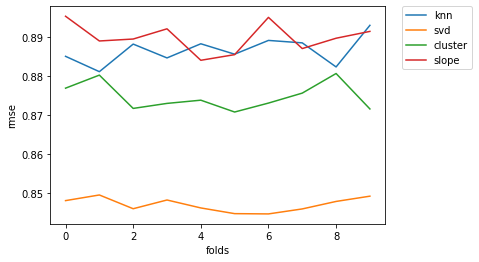

In [22]:
#Отобразим предсказания:
import matplotlib.pyplot as plt
modelPrediction = plt.plot(rmseKNN, label='knn')
modelPrediction = plt.plot(rmseSVD, label='svd')
modelPrediction = plt.plot(rmseCo, label='cluster')
modelPrediction = plt.plot(rmseSlope, label='slope')

modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('rmse')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Похоже, что svd превосходит остальные. Попробуем гибридизировать модели, чтобы получить лучшие части каждой модели. Для этого мы собираемся использовать Suprise, чтобы создать новый алгоритм, и сделать так, чтобы он превосходил остальные.


# На псевдокоде наш алгоритм выглядит следующим образом:
1. Мы запускаем несколько рекомендательных систем для набора данных.
2. Инициализируем взвешенную переменную alpha равную 1 / q, где q - количество используемых нами рекомендательных систем.
3. Итоговый рейтинг будем считать как сумму взвещаных прогнозируемых рейтингов.
4. Используя градиентный спуск, оптимизируем альфа-член по пространству параметров, чтобы иметь возможность придать наибольший вес модели, которая может представлять лучший прогноз.

Теперь создадим класс в Surprise и унаследуем его от Algobase.

In [24]:
class HybridFacto(surprise.AlgoBase):
    
    def __init__(self, estimators=None, epochs=10, learning_rate=.05, q=4):
        if estimators is None:
            self.__stub_mode = True
            return
        self.alpha = np.array([1 / q] * q)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.collabKNN = estimators[0]
        self.funkSVD = estimators[1]
        self.coClus = estimators[2]
        self.slopeOne = estimators[3]
        self.__stub_mode = False
    
    def fit(self, train_set):
        holdout=train_set.build_full_trainset().build_testset()
        predictions = []
        predictions.append(self.collabKNN.test(holdout))
        predictions.append(self.funkSVD.test(holdout))
        predictions.append(self.coClus.test(holdout))
        predictions.append(self.slopeOne.test(holdout))
        for epoch in range(self.epochs):
            maeGradient = np.array([surprise.accuracy.mae(prediction) for prediction in predictions])
            newalpha =  self.alpha - maeGradient * self.learning_rate
            #проверка сходимости:
            if (newalpha - self.alpha).max() < 0.001:
                break
            self.alpha = newalpha
            
    def estimate(self,testset):
        if self.__stub_mode:
            return [0.0]
        algoResults=[np.array([i.est for i in self.collabKNN.test(testset)]),
                     np.array([i.est for i in self.funkSVD.test(testset)]),
                     np.array([i.est for i in self.coClus.test(testset)]),
                     np.array([i.est for i in self.slopeOne.test(testset)])]
        return self.alpha @ algoResults
        
        
    def dump_instance(self, dump_path):
        with open(dump_path, 'wb') as dump_file:
            pickle.dump(self, dump_file, pickle.HIGHEST_PROTOCOL)
     
    
    @staticmethod
    def load_instance_from_dump(dump_path):
        with open(dump_path, 'rb') as dump_file:
            return pickle.load(dump_file)
        

давайте проверим его:
1. Инициализруйте Гибридную модель с 10 эпохами, learning_rate = 0.05, по 4 имеющимся моделям и обучите на holdout выборке
2. Посчитайте root mean squared error с использованием метрики из sklearn для получившегося результата
3. Отобразите на графике результаты метрики, полученые от одиночных моделей на предыдущих шагах вместе с результатом гибридной модели. Оцените результат

In [65]:
from sklearn.metrics import mean_squared_error
from math import sqrt

estimators = [collabKNN,\
              funkSVD,\
              coClus,\
              slopeOne]

hybrid = HybridFacto(estimators)
hybrid.fit(holdout)
kSplit = model_selection.split.KFold(n_splits=10, shuffle=True)

rmseHyb = []
for trainset, testset in kSplit.split(data):
    predhybrid = hybrid.estimate(testset)
    test_r = [i[2] for i in testset]
    fold_rmse = mean_squared_error(test_r, predhybrid)
    rmseHyb.append(fold_rmse)

MAE:  0.7803
MAE:  0.7228
MAE:  0.7803
MAE:  0.7803


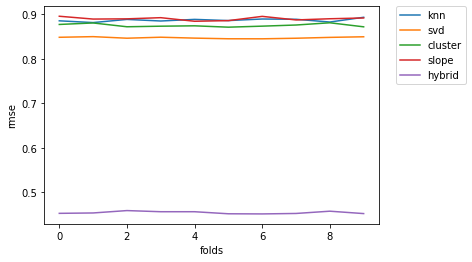

In [67]:
#plotting the prediction data:
modelPrediction = plt.plot(rmseKNN, label='knn')
modelPrediction = plt.plot(rmseSVD, label='svd')
modelPrediction = plt.plot(rmseCo, label='cluster')
modelPrediction = plt.plot(rmseSlope, label='slope')
modelPrediction = plt.plot(rmseHyb, label='hybrid')

modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('rmse')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Задание

Сохраните обученные модели для использования гибридного подхода и реализуйте возможность предсказания результата для id пользователя и фильма через веб-интерфейс с помощью REST-API фреймворка (flask/django)

In [68]:
hybrid.dump_instance('/content/drive/MyDrive/recomendation.pkl')

In [69]:
hybrid_loaded_from_dump = HybridFacto.load_instance_from_dump('/content/drive/MyDrive/recomendation.pkl')

In [77]:
to_predict = [(1, 1000, None)]
predicted = hybrid_loaded_from_dump.estimate(to_predict)
print(predicted)

[3.76252573]
